<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/mlp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Thesis/cnn-soc-wagga


In [3]:
# Standard lib imports
import os
import pathlib
import random

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize, dump, load
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence, plot_evaluations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
import pdb  # Brug det

In [4]:
# ------------------- TO DO ------------------------------------------------- #

"""
Use Torch Dataset.. you made a class for it dummy
Should I shuffle train_loader in CV?
"""

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.format'] = 'svg'

# Reset params if needed
# plt.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')


def seed_everything(SEED=43):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED']=str(SEED)
    torch.backends.cudnn.benchmark = False


SEED = 43
seed_everything(SEED=SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
# ------------------- Read and prep data ------------------------------------ #

train_data = np.load(DATA_DIR.joinpath('train_no_outlier.npy'))
test_data = np.load(DATA_DIR.joinpath('test_no_outlier.npy'))

x_train = train_data[:, 1:]
y_train = train_data[:, 0]

input_shape=x_train.shape[-1]

x_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Normalize X
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

# Normalize y
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# There is no reason to scale y_test actually
y_test = scaler_y.transform(y_test.reshape(-1, 1))


x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
x_test, y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

class Dataset(torch.utils.data.TensorDataset):
    """Characterize a PyTorch Dataset."""

    def __init__(self, features, targets):
        """Initialize with X and y."""
        self.features = features
        self.targets = targets

    def __len__(self):
        """Return total number of samples."""
        return len(self.targets)

    def __getitem__(self, index):
        """Generate one data sample."""
        return self.features[index], self.targets[index]

In [6]:
# ------------------- NN setup ---------------------------------------------- #


class NeuralNet(nn.Module):
    """Neural Network class."""

    def __init__(self, input_dims=input_shape, activation=nn.ELU(), dropout=0.5):
        """Initialize as subclass of nn.Module, inherit its methods."""
        super(NeuralNet, self).__init__()

        self.input_dims = input_dims
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout)

        # Layer structure
        self.fc1 = nn.Linear(self.input_dims, 256)
        self.b1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.b2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.b3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.b4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        """Forward pass."""
        x = self.fc1(x)
        x = self.dropout(x)  # set mode?
        x = self.activation(x)
        x = self.b1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.b2(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.b3(x)
        x = self.fc4(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.b4(x)
        x = self.fc5(x)

        return x


def train_step(model, features, targets, optimizer, loss_fn):
    """Perform a single training step.

    Calulcates prediction, loss and gradients for a single batch
    and updates optimizer parameters accordingly."""

    # Set gradients to zero
    model.zero_grad()
    # Pass data through model
    output = model(features)
    # Calculate loss
    loss = loss_fn(output, targets)
    # Calculate gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    return loss, output


def train_network(model, train_data, val_data, optimizer, loss_fn,
                  n_epochs=300, patience=20, print_progress=True):
    """Train a neural network model."""
    # Initalize loss as very high
    best_loss = 1e8

    # Create lists to hold train and val losses
    train_loss = []
    val_loss = []
    # Init epochs_no_improve
    epochs_no_improve = 0
    # best_model = copy.deepcopy(model.state_dict())
    
    # Start training (loop over epochs)
    for epoch in range(n_epochs):

        # Initalize epoch train loss
        train_epoch_loss = 0
        # Loop over training batches
        model.train()  # set model to training mode for training
        for bidx, (features, targets) in enumerate(train_data):
            # Calculate loss and predictions
            loss, predictions = train_step(model, features, targets,
                                           optimizer, loss_fn)
            train_epoch_loss += loss
        # Save train epoch loss
        train_loss.append(train_epoch_loss.item())

        # Initialize val epoch loss
        val_epoch_loss = 0
        # Loop over validation batches
        model.eval()  # set model to evaluation mode for validation
        for bidx, (features, targets) in enumerate(val_data):
            output = model(features)
            val_epoch_loss += loss_fn(output, targets)
        # Save val epoch loss
        val_loss.append(val_epoch_loss.item())

        # Early stopping (check if val loss is an improvement on current best)
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss.item()
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f'Stopping after {epoch} epochs due to no improvement.')
                model.load_state_dict(best_model)
                break
        # Print progress at set epoch intervals if desired
        if print_progress:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1} Train Loss: {train_epoch_loss:.4}, ', end='')
                print(f'Val Loss: {val_epoch_loss:.4}')

    return train_loss, val_loss


def weight_reset(m):
    """Reset all weights in an NN."""
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [7]:
# ------------------- Cross-validation -------------------------------------- #

model = NeuralNet(activation=nn.ELU(), dropout=0.5)
lr = 1e-3
regu = 1e-2
# SGD/RMSProp
# L1 regu
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=regu)
loss_fn = nn.MSELoss()
batch_size = 312
n_epochs = 2000
n_splits = 5
patience = 100


def kfold_cv_train(x_train=x_train, y_train=y_train, model=model, optimizer=optimizer,
                    loss_fn=nn.MSELoss(), n_splits=5, batch_size=128,
                    n_epochs=500, patience=100, shuffle=True, rng=SEED):
    """Train a NN with K-Fold cross-validation."""
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rng)
    best_losses = []


    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        # print(f'Starting fold {fold + 1}')
        # Get training and val features
        x_train_fold = x_train[train_index]
        x_val_fold = x_train[val_index]

        # Get training and val targets
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        train = Dataset(x_train_fold, y_train_fold)
        train_loader = DataLoader(train, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=True)
        # Create val dataset and dataloader
        val = Dataset(x_val_fold, y_val_fold)
        val_loader = DataLoader(val, batch_size=batch_size,
                                shuffle=False, drop_last=False)

        # Train
        train_loss, val_loss = train_network(model=model,
                                             train_data=train_loader,
                                             val_data=val_loader,
                                             optimizer=optimizer,
                                             loss_fn=loss_fn,
                                             n_epochs=n_epochs,
                                             patience=patience,
                                             print_progress=False)
        best_losses.append(min(val_loss))
        model.apply(weight_reset)

    return best_losses, train_loss, val_loss


Gaussian Process:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at provided point.
Stopping after 299 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.


Gaussian Process:   0%|          | 1/200 [00:38<2:06:50, 38.24s/it]

Stopping after 263 epochs due to no improvement.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 38.2355
Function value obtained: 0.0147
Current minimum: 0.0147
Iteration No: 2 started. Evaluating function at random point.
Stopping after 140 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.


Gaussian Process:   1%|          | 2/200 [01:36<2:26:19, 44.34s/it]

Stopping after 155 epochs due to no improvement.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 58.5793
Function value obtained: 0.0567
Current minimum: 0.0147
Iteration No: 3 started. Evaluating function at random point.
Stopping after 244 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 412 epochs due to no improvement.


Gaussian Process:   2%|▏         | 3/200 [02:24<2:29:01, 45.39s/it]

Stopping after 204 epochs due to no improvement.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 47.8320
Function value obtained: 0.0302
Current minimum: 0.0147
Iteration No: 4 started. Evaluating function at random point.
Stopping after 130 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.


Gaussian Process:   2%|▏         | 4/200 [04:44<4:01:12, 73.84s/it]

Stopping after 197 epochs due to no improvement.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 140.2195
Function value obtained: 0.1270
Current minimum: 0.0147
Iteration No: 5 started. Evaluating function at random point.
Stopping after 199 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.


Gaussian Process:   2%|▎         | 5/200 [05:22<3:24:39, 62.97s/it]

Stopping after 270 epochs due to no improvement.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 37.6208
Function value obtained: 0.0303
Current minimum: 0.0147
Iteration No: 6 started. Evaluating function at random point.
Stopping after 175 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.


Gaussian Process:   3%|▎         | 6/200 [05:59<2:58:09, 55.10s/it]

Stopping after 243 epochs due to no improvement.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 36.7383
Function value obtained: 0.0280
Current minimum: 0.0147
Iteration No: 7 started. Evaluating function at random point.
Stopping after 500 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.


Gaussian Process:   4%|▎         | 7/200 [06:52<2:55:19, 54.51s/it]

Stopping after 105 epochs due to no improvement.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 53.1132
Function value obtained: 0.0355
Current minimum: 0.0147
Iteration No: 8 started. Evaluating function at random point.
Stopping after 191 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.


Gaussian Process:   4%|▍         | 8/200 [07:57<3:04:17, 57.59s/it]

Stopping after 177 epochs due to no improvement.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 64.7813
Function value obtained: 0.0592
Current minimum: 0.0147
Iteration No: 9 started. Evaluating function at random point.
Stopping after 210 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.


Gaussian Process:   4%|▍         | 9/200 [09:06<3:14:52, 61.22s/it]

Stopping after 364 epochs due to no improvement.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 69.6853
Function value obtained: 0.0281
Current minimum: 0.0147
Iteration No: 10 started. Evaluating function at random point.
Stopping after 154 epochs due to no improvement.
Stopping after 383 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 420 epochs due to no improvement.


Gaussian Process:   5%|▌         | 10/200 [09:59<3:05:31, 58.59s/it]

Stopping after 470 epochs due to no improvement.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 52.4560
Function value obtained: 0.0219
Current minimum: 0.0147
Iteration No: 11 started. Evaluating function at random point.
Stopping after 169 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 419 epochs due to no improvement.
Stopping after 868 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.


Gaussian Process:   6%|▌         | 11/200 [10:58<3:05:33, 58.91s/it]

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 59.6462
Function value obtained: 0.0241
Current minimum: 0.0147
Iteration No: 12 started. Evaluating function at random point.
Stopping after 847 epochs due to no improvement.
Stopping after 1996 epochs due to no improvement.
Stopping after 1140 epochs due to no improvement.
Stopping after 1025 epochs due to no improvement.
Stopping after 873 epochs due to no improvement.


Gaussian Process:   6%|▌         | 12/200 [13:20<4:21:51, 83.57s/it]

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 141.1146
Function value obtained: 0.0169
Current minimum: 0.0147
Iteration No: 13 started. Searching for the next optimal point.
Stopping after 118 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.


Gaussian Process:   6%|▋         | 13/200 [13:37<3:18:20, 63.64s/it]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 17.1270
Function value obtained: 0.0181
Current minimum: 0.0147
Iteration No: 14 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 1129 epochs due to no improvement.
Stopping after 1131 epochs due to no improvement.
Stopping after 824 epochs due to no improvement.


Gaussian Process:   7%|▋         | 14/200 [16:11<4:41:23, 90.77s/it]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 154.0934
Function value obtained: 0.0495
Current minimum: 0.0147
Iteration No: 15 started. Searching for the next optimal point.
Stopping after 171 epochs due to no improvement.
Stopping after 461 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.


Gaussian Process:   8%|▊         | 15/200 [16:42<3:44:35, 72.84s/it]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 30.9914
Function value obtained: 0.0152
Current minimum: 0.0147
Iteration No: 16 started. Searching for the next optimal point.
Stopping after 111 epochs due to no improvement.
Stopping after 1003 epochs due to no improvement.
Stopping after 1065 epochs due to no improvement.
Stopping after 1216 epochs due to no improvement.


Gaussian Process:   8%|▊         | 16/200 [18:48<4:32:48, 88.96s/it]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 126.5735
Function value obtained: 0.0334
Current minimum: 0.0147
Iteration No: 17 started. Searching for the next optimal point.
Stopping after 1097 epochs due to no improvement.
Stopping after 774 epochs due to no improvement.
Stopping after 541 epochs due to no improvement.
Stopping after 317 epochs due to no improvement.
Stopping after 499 epochs due to no improvement.


Gaussian Process:   8%|▊         | 17/200 [21:26<5:34:30, 109.67s/it]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 158.0021
Function value obtained: 0.0474
Current minimum: 0.0147
Iteration No: 18 started. Searching for the next optimal point.
Stopping after 196 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.


Gaussian Process:   9%|▉         | 18/200 [22:38<4:57:51, 98.19s/it] 

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 71.4063
Function value obtained: 0.0447
Current minimum: 0.0147
Iteration No: 19 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.


Gaussian Process:  10%|▉         | 19/200 [22:55<3:43:23, 74.05s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 17.7278
Function value obtained: 0.0181
Current minimum: 0.0147
Iteration No: 20 started. Searching for the next optimal point.
Stopping after 222 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 375 epochs due to no improvement.
Stopping after 608 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.


Gaussian Process:  10%|█         | 20/200 [23:30<3:06:48, 62.27s/it]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 34.7710
Function value obtained: 0.0371
Current minimum: 0.0147
Iteration No: 21 started. Searching for the next optimal point.
Stopping after 834 epochs due to no improvement.
Stopping after 747 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1615 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.


Gaussian Process:  10%|█         | 21/200 [24:55<3:25:58, 69.04s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 84.8536
Function value obtained: 0.0252
Current minimum: 0.0147
Iteration No: 22 started. Searching for the next optimal point.
Stopping after 163 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.


Gaussian Process:  11%|█         | 22/200 [25:13<2:39:07, 53.64s/it]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 17.6807
Function value obtained: 0.0180
Current minimum: 0.0147
Iteration No: 23 started. Searching for the next optimal point.
Stopping after 169 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.


Gaussian Process:  12%|█▏        | 23/200 [25:34<2:09:32, 43.91s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 21.2268
Function value obtained: 0.0321
Current minimum: 0.0147
Iteration No: 24 started. Searching for the next optimal point.
Stopping after 186 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.


Gaussian Process:  12%|█▏        | 24/200 [26:11<2:02:24, 41.73s/it]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 36.6410
Function value obtained: 0.0288
Current minimum: 0.0147
Iteration No: 25 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 815 epochs due to no improvement.


Gaussian Process:  12%|█▎        | 25/200 [27:26<2:31:33, 51.96s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 75.8321
Function value obtained: 0.0235
Current minimum: 0.0147
Iteration No: 26 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 531 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 870 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  13%|█▎        | 26/200 [28:39<2:48:12, 58.00s/it]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 72.0962
Function value obtained: 0.0440
Current minimum: 0.0147
Iteration No: 27 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.


Gaussian Process:  14%|█▎        | 27/200 [28:57<2:13:10, 46.19s/it]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 18.6298
Function value obtained: 0.0180
Current minimum: 0.0147
Iteration No: 28 started. Searching for the next optimal point.
Stopping after 225 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.


Gaussian Process:  14%|█▍        | 28/200 [29:59<2:26:08, 50.98s/it]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 62.1559
Function value obtained: 0.0287
Current minimum: 0.0147
Iteration No: 29 started. Searching for the next optimal point.
Stopping after 121 epochs due to no improvement.
Stopping after 353 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.


Gaussian Process:  14%|█▍        | 29/200 [30:31<2:08:35, 45.12s/it]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 31.4410
Function value obtained: 0.0342
Current minimum: 0.0147
Iteration No: 30 started. Searching for the next optimal point.
Stopping after 213 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.
Stopping after 501 epochs due to no improvement.
Stopping after 1080 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.


Gaussian Process:  15%|█▌        | 30/200 [31:45<2:32:11, 53.72s/it]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 73.7741
Function value obtained: 0.0256
Current minimum: 0.0147
Iteration No: 31 started. Searching for the next optimal point.
Stopping after 434 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.


Gaussian Process:  16%|█▌        | 31/200 [32:21<2:16:21, 48.41s/it]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 36.0336
Function value obtained: 0.0145
Current minimum: 0.0145
Iteration No: 32 started. Searching for the next optimal point.
Stopping after 305 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.
Stopping after 782 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.
Stopping after 856 epochs due to no improvement.


Gaussian Process:  16%|█▌        | 32/200 [33:19<2:24:09, 51.49s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 58.6585
Function value obtained: 0.0158
Current minimum: 0.0145
Iteration No: 33 started. Searching for the next optimal point.
Stopping after 234 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.


Gaussian Process:  16%|█▋        | 33/200 [33:38<1:55:44, 41.59s/it]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 18.4880
Function value obtained: 0.0261
Current minimum: 0.0145
Iteration No: 34 started. Searching for the next optimal point.
Stopping after 433 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  17%|█▋        | 34/200 [34:05<1:42:48, 37.16s/it]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 26.8337
Function value obtained: 0.0343
Current minimum: 0.0145
Iteration No: 35 started. Searching for the next optimal point.
Stopping after 298 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  18%|█▊        | 35/200 [34:38<1:38:51, 35.95s/it]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 33.1270
Function value obtained: 0.0363
Current minimum: 0.0145
Iteration No: 36 started. Searching for the next optimal point.
Stopping after 632 epochs due to no improvement.
Stopping after 991 epochs due to no improvement.
Stopping after 1428 epochs due to no improvement.
Stopping after 814 epochs due to no improvement.
Stopping after 424 epochs due to no improvement.


Gaussian Process:  18%|█▊        | 36/200 [37:26<3:26:28, 75.54s/it]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 167.9200
Function value obtained: 0.0311
Current minimum: 0.0145
Iteration No: 37 started. Searching for the next optimal point.
Stopping after 299 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.


Gaussian Process:  18%|█▊        | 37/200 [37:54<2:46:29, 61.28s/it]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 28.0127
Function value obtained: 0.0147
Current minimum: 0.0145
Iteration No: 38 started. Searching for the next optimal point.
Stopping after 318 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 716 epochs due to no improvement.
Stopping after 898 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.


Gaussian Process:  19%|█▉        | 38/200 [39:18<3:04:32, 68.35s/it]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 84.8369
Function value obtained: 0.0312
Current minimum: 0.0145
Iteration No: 39 started. Searching for the next optimal point.
Stopping after 173 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.


Gaussian Process:  20%|█▉        | 39/200 [39:54<2:37:08, 58.56s/it]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 35.7227
Function value obtained: 0.0248
Current minimum: 0.0145
Iteration No: 40 started. Searching for the next optimal point.
Stopping after 126 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1051 epochs due to no improvement.


Gaussian Process:  20%|██        | 40/200 [40:31<2:18:21, 51.89s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 36.3100
Function value obtained: 0.0365
Current minimum: 0.0145
Iteration No: 41 started. Searching for the next optimal point.
Stopping after 188 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.


Gaussian Process:  20%|██        | 41/200 [41:00<1:59:21, 45.04s/it]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 29.0754
Function value obtained: 0.0149
Current minimum: 0.0145
Iteration No: 42 started. Searching for the next optimal point.
Stopping after 291 epochs due to no improvement.
Stopping after 856 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 1205 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.


Gaussian Process:  21%|██        | 42/200 [42:09<2:17:52, 52.36s/it]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 69.4307
Function value obtained: 0.0147
Current minimum: 0.0145
Iteration No: 43 started. Searching for the next optimal point.
Stopping after 220 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.
Stopping after 435 epochs due to no improvement.
Stopping after 458 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.


Gaussian Process:  22%|██▏       | 43/200 [43:44<2:50:36, 65.20s/it]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 95.1614
Function value obtained: 0.0449
Current minimum: 0.0145
Iteration No: 44 started. Searching for the next optimal point.
Stopping after 385 epochs due to no improvement.
Stopping after 915 epochs due to no improvement.
Stopping after 519 epochs due to no improvement.
Stopping after 699 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.


Gaussian Process:  22%|██▏       | 44/200 [44:51<2:50:51, 65.72s/it]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 66.9127
Function value obtained: 0.0153
Current minimum: 0.0145
Iteration No: 45 started. Searching for the next optimal point.
Stopping after 315 epochs due to no improvement.
Stopping after 433 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.


Gaussian Process:  22%|██▎       | 45/200 [45:33<2:31:12, 58.53s/it]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 41.7822
Function value obtained: 0.0146
Current minimum: 0.0145
Iteration No: 46 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.


Gaussian Process:  23%|██▎       | 46/200 [45:56<2:03:08, 47.98s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 23.3476
Function value obtained: 0.0357
Current minimum: 0.0145
Iteration No: 47 started. Searching for the next optimal point.
Stopping after 188 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.


Gaussian Process:  24%|██▎       | 47/200 [46:19<1:43:17, 40.50s/it]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 23.0611
Function value obtained: 0.0153
Current minimum: 0.0145
Iteration No: 48 started. Searching for the next optimal point.
Stopping after 325 epochs due to no improvement.
Stopping after 383 epochs due to no improvement.
Stopping after 744 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.


Gaussian Process:  24%|██▍       | 48/200 [47:18<1:56:19, 45.91s/it]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 58.5384
Function value obtained: 0.0340
Current minimum: 0.0145
Iteration No: 49 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 163 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.


Gaussian Process:  24%|██▍       | 49/200 [47:37<1:35:00, 37.75s/it]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 18.6959
Function value obtained: 0.0181
Current minimum: 0.0145
Iteration No: 50 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.


Gaussian Process:  25%|██▌       | 50/200 [47:58<1:22:03, 32.83s/it]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 21.3437
Function value obtained: 0.0273
Current minimum: 0.0145
Iteration No: 51 started. Searching for the next optimal point.
Stopping after 152 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.


Gaussian Process:  26%|██▌       | 51/200 [48:16<1:10:41, 28.47s/it]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 18.2895
Function value obtained: 0.0181
Current minimum: 0.0145
Iteration No: 52 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 526 epochs due to no improvement.
Stopping after 977 epochs due to no improvement.
Stopping after 618 epochs due to no improvement.


Gaussian Process:  26%|██▌       | 52/200 [49:49<1:57:52, 47.79s/it]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 92.8618
Function value obtained: 0.0344
Current minimum: 0.0145
Iteration No: 53 started. Searching for the next optimal point.
Stopping after 226 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.


Gaussian Process:  26%|██▋       | 53/200 [50:19<1:44:01, 42.46s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 30.0208
Function value obtained: 0.0151
Current minimum: 0.0145
Iteration No: 54 started. Searching for the next optimal point.
Stopping after 230 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.


Gaussian Process:  27%|██▋       | 54/200 [50:47<1:32:41, 38.10s/it]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 27.9204
Function value obtained: 0.0145
Current minimum: 0.0145
Iteration No: 55 started. Searching for the next optimal point.
Stopping after 126 epochs due to no improvement.
Stopping after 425 epochs due to no improvement.
Stopping after 694 epochs due to no improvement.
Stopping after 898 epochs due to no improvement.
Stopping after 745 epochs due to no improvement.


Gaussian Process:  28%|██▊       | 55/200 [52:29<2:18:05, 57.14s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 101.5727
Function value obtained: 0.0290
Current minimum: 0.0145
Iteration No: 56 started. Searching for the next optimal point.
Stopping after 179 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.


Gaussian Process:  28%|██▊       | 56/200 [52:54<1:53:58, 47.49s/it]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 24.9705
Function value obtained: 0.0145
Current minimum: 0.0145
Iteration No: 57 started. Searching for the next optimal point.
Stopping after 273 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 544 epochs due to no improvement.
Stopping after 501 epochs due to no improvement.


Gaussian Process:  28%|██▊       | 57/200 [54:11<2:14:43, 56.53s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 77.6112
Function value obtained: 0.0300
Current minimum: 0.0145
Iteration No: 58 started. Searching for the next optimal point.
Stopping after 212 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.


Gaussian Process:  29%|██▉       | 58/200 [54:40<1:53:48, 48.09s/it]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 28.4049
Function value obtained: 0.0146
Current minimum: 0.0145
Iteration No: 59 started. Searching for the next optimal point.
Stopping after 527 epochs due to no improvement.
Stopping after 377 epochs due to no improvement.
Stopping after 603 epochs due to no improvement.
Stopping after 720 epochs due to no improvement.


Gaussian Process:  30%|██▉       | 59/200 [58:46<4:12:59, 107.65s/it]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 246.6412
Function value obtained: 0.0547
Current minimum: 0.0145
Iteration No: 60 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.


Gaussian Process:  30%|███       | 60/200 [59:05<3:08:51, 80.94s/it] 

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 18.6111
Function value obtained: 0.0180
Current minimum: 0.0145
Iteration No: 61 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 1259 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.


Gaussian Process:  30%|███       | 61/200 [59:45<2:39:02, 68.65s/it]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 39.9628
Function value obtained: 0.0172
Current minimum: 0.0145
Iteration No: 62 started. Searching for the next optimal point.
Stopping after 165 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 605 epochs due to no improvement.
Stopping after 1089 epochs due to no improvement.


Gaussian Process:  31%|███       | 62/200 [1:00:39<2:28:06, 64.40s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 54.4832
Function value obtained: 0.0159
Current minimum: 0.0145
Iteration No: 63 started. Searching for the next optimal point.
Stopping after 197 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.


Gaussian Process:  32%|███▏      | 63/200 [1:01:07<2:02:04, 53.46s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 27.9430
Function value obtained: 0.0141
Current minimum: 0.0141
Iteration No: 64 started. Searching for the next optimal point.
Stopping after 196 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.


Gaussian Process:  32%|███▏      | 64/200 [1:01:33<1:42:08, 45.07s/it]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 25.4717
Function value obtained: 0.0146
Current minimum: 0.0141
Iteration No: 65 started. Searching for the next optimal point.
Stopping after 691 epochs due to no improvement.
Stopping after 692 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 950 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  32%|███▎      | 65/200 [1:03:00<2:10:04, 57.81s/it]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 87.5379
Function value obtained: 0.0358
Current minimum: 0.0141
Iteration No: 66 started. Searching for the next optimal point.
Stopping after 180 epochs due to no improvement.
Stopping after 336 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.


Gaussian Process:  33%|███▎      | 66/200 [1:03:41<1:57:38, 52.68s/it]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 40.7045
Function value obtained: 0.0242
Current minimum: 0.0141
Iteration No: 67 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.


Gaussian Process:  34%|███▎      | 67/200 [1:04:31<1:54:55, 51.85s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 49.9185
Function value obtained: 0.0244
Current minimum: 0.0141
Iteration No: 68 started. Searching for the next optimal point.
Stopping after 121 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 490 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.


Gaussian Process:  34%|███▍      | 68/200 [1:05:02<1:40:11, 45.54s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 30.8297
Function value obtained: 0.0171
Current minimum: 0.0141
Iteration No: 69 started. Searching for the next optimal point.
Stopping after 264 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 247 epochs due to no improvement.


Gaussian Process:  34%|███▍      | 69/200 [1:05:28<1:26:35, 39.66s/it]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 25.9394
Function value obtained: 0.0157
Current minimum: 0.0141
Iteration No: 70 started. Searching for the next optimal point.
Stopping after 294 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 500 epochs due to no improvement.
Stopping after 367 epochs due to no improvement.
Stopping after 1087 epochs due to no improvement.


Gaussian Process:  35%|███▌      | 70/200 [1:06:54<1:56:37, 53.82s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 86.8693
Function value obtained: 0.0289
Current minimum: 0.0141
Iteration No: 71 started. Searching for the next optimal point.
Stopping after 207 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.


Gaussian Process:  36%|███▌      | 71/200 [1:07:22<1:38:29, 45.81s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 27.1039
Function value obtained: 0.0138
Current minimum: 0.0138
Iteration No: 72 started. Searching for the next optimal point.
Stopping after 190 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 341 epochs due to no improvement.


Gaussian Process:  36%|███▌      | 72/200 [1:07:49<1:26:09, 40.39s/it]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 27.7396
Function value obtained: 0.0146
Current minimum: 0.0138
Iteration No: 73 started. Searching for the next optimal point.
Stopping after 793 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 407 epochs due to no improvement.
Stopping after 539 epochs due to no improvement.
Stopping after 378 epochs due to no improvement.


Gaussian Process:  36%|███▋      | 73/200 [1:08:44<1:34:38, 44.72s/it]/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 54.8165
Function value obtained: 0.0160
Current minimum: 0.0138
Iteration No: 74 started. Searching for the next optimal point.
Stopping after 231 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.


Gaussian Process:  37%|███▋      | 74/200 [1:09:12<1:23:00, 39.52s/it]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 27.4108
Function value obtained: 0.0146
Current minimum: 0.0138
Iteration No: 75 started. Searching for the next optimal point.
Stopping after 134 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.


Gaussian Process:  38%|███▊      | 75/200 [1:09:29<1:08:32, 32.90s/it]

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 17.4351
Function value obtained: 0.0181
Current minimum: 0.0138
Iteration No: 76 started. Searching for the next optimal point.
Stopping after 153 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.


Gaussian Process:  38%|███▊      | 76/200 [1:09:46<58:09, 28.14s/it]  

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 17.0308
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 77 started. Searching for the next optimal point.
Stopping after 272 epochs due to no improvement.
Stopping after 380 epochs due to no improvement.
Stopping after 732 epochs due to no improvement.
Stopping after 632 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.


Gaussian Process:  38%|███▊      | 77/200 [1:11:17<1:36:17, 46.97s/it]

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 90.9159
Function value obtained: 0.0291
Current minimum: 0.0138
Iteration No: 78 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.


Gaussian Process:  39%|███▉      | 78/200 [1:11:40<1:20:43, 39.70s/it]

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 22.7485
Function value obtained: 0.0180
Current minimum: 0.0138
Iteration No: 79 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  40%|███▉      | 79/200 [1:11:54<1:04:43, 32.09s/it]

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 14.3305
Function value obtained: 0.0465
Current minimum: 0.0138
Iteration No: 80 started. Searching for the next optimal point.
Stopping after 124 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.


Gaussian Process:  40%|████      | 80/200 [1:12:10<54:38, 27.32s/it]  

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 16.1960
Function value obtained: 0.0141
Current minimum: 0.0138
Iteration No: 81 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.


Gaussian Process:  40%|████      | 81/200 [1:12:28<48:31, 24.47s/it]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 17.8106
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 82 started. Searching for the next optimal point.
Stopping after 118 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.


Gaussian Process:  41%|████      | 82/200 [1:12:44<43:22, 22.06s/it]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 16.4225
Function value obtained: 0.0145
Current minimum: 0.0138
Iteration No: 83 started. Searching for the next optimal point.
Stopping after 131 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.


Gaussian Process:  42%|████▏     | 83/200 [1:13:10<45:04, 23.12s/it]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 25.5923
Function value obtained: 0.0143
Current minimum: 0.0138
Iteration No: 84 started. Searching for the next optimal point.
Stopping after 149 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.


Gaussian Process:  42%|████▏     | 84/200 [1:13:27<41:04, 21.24s/it]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 16.8750
Function value obtained: 0.0148
Current minimum: 0.0138
Iteration No: 85 started. Searching for the next optimal point.
Stopping after 159 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 146 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 302 epochs due to no improvement.


Gaussian Process:  42%|████▎     | 85/200 [1:13:54<44:03, 22.99s/it]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 27.0584
Function value obtained: 0.0149
Current minimum: 0.0138
Iteration No: 86 started. Searching for the next optimal point.
Stopping after 226 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.


Gaussian Process:  43%|████▎     | 86/200 [1:14:25<48:24, 25.48s/it]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 31.2933
Function value obtained: 0.0143
Current minimum: 0.0138
Iteration No: 87 started. Searching for the next optimal point.
Stopping after 118 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.


Gaussian Process:  44%|████▎     | 87/200 [1:15:12<1:00:02, 31.88s/it]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 46.8094
Function value obtained: 0.0320
Current minimum: 0.0138
Iteration No: 88 started. Searching for the next optimal point.
Stopping after 116 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.


Gaussian Process:  44%|████▍     | 88/200 [1:15:29<51:17, 27.48s/it]  

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 17.2073
Function value obtained: 0.0149
Current minimum: 0.0138
Iteration No: 89 started. Searching for the next optimal point.
Stopping after 138 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.


Gaussian Process:  44%|████▍     | 89/200 [1:15:51<47:28, 25.67s/it]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 21.4413
Function value obtained: 0.0254
Current minimum: 0.0138
Iteration No: 90 started. Searching for the next optimal point.
Stopping after 255 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.


Gaussian Process:  45%|████▌     | 90/200 [1:17:53<1:40:23, 54.76s/it]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 122.6431
Function value obtained: 0.0837
Current minimum: 0.0138
Iteration No: 91 started. Searching for the next optimal point.
Stopping after 284 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 422 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.


Gaussian Process:  46%|████▌     | 91/200 [1:18:35<1:32:33, 50.95s/it]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 42.0510
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 92 started. Searching for the next optimal point.
Stopping after 121 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.


Gaussian Process:  46%|████▌     | 92/200 [1:19:27<1:32:07, 51.18s/it]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 51.7351
Function value obtained: 0.1310
Current minimum: 0.0138
Iteration No: 93 started. Searching for the next optimal point.
Stopping after 368 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.


Gaussian Process:  46%|████▋     | 93/200 [1:20:05<1:24:07, 47.17s/it]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 37.8150
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 94 started. Searching for the next optimal point.
Stopping after 231 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.


Gaussian Process:  47%|████▋     | 94/200 [1:23:30<2:47:10, 94.63s/it]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 205.3568
Function value obtained: 0.1585
Current minimum: 0.0138
Iteration No: 95 started. Searching for the next optimal point.
Stopping after 257 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.


Gaussian Process:  48%|████▊     | 95/200 [1:24:00<2:11:27, 75.12s/it]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 29.6019
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 96 started. Searching for the next optimal point.
Stopping after 239 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.


Gaussian Process:  48%|████▊     | 96/200 [1:24:28<1:45:54, 61.10s/it]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 28.3930
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 97 started. Searching for the next optimal point.
Stopping after 204 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.


Gaussian Process:  48%|████▊     | 97/200 [1:24:54<1:26:27, 50.36s/it]

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 25.3065
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 98 started. Searching for the next optimal point.
Stopping after 275 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.


Gaussian Process:  49%|████▉     | 98/200 [1:25:29<1:17:50, 45.78s/it]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 35.1008
Function value obtained: 0.0143
Current minimum: 0.0138
Iteration No: 99 started. Searching for the next optimal point.
Stopping after 297 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.
Stopping after 1037 epochs due to no improvement.


Gaussian Process:  50%|████▉     | 99/200 [1:26:46<1:32:50, 55.15s/it]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 77.0170
Function value obtained: 0.0319
Current minimum: 0.0138
Iteration No: 100 started. Searching for the next optimal point.
Stopping after 1336 epochs due to no improvement.
Stopping after 567 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 1166 epochs due to no improvement.
Stopping after 1010 epochs due to no improvement.


Gaussian Process:  50%|█████     | 100/200 [1:29:39<2:30:57, 90.58s/it]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 173.2358
Function value obtained: 0.0378
Current minimum: 0.0138
Iteration No: 101 started. Searching for the next optimal point.
Stopping after 320 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.


Gaussian Process:  50%|█████     | 101/200 [1:30:16<2:03:11, 74.66s/it]

Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 37.5133
Function value obtained: 0.0143
Current minimum: 0.0138
Iteration No: 102 started. Searching for the next optimal point.
Stopping after 291 epochs due to no improvement.
Stopping after 261 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 451 epochs due to no improvement.


Gaussian Process:  51%|█████     | 102/200 [1:30:57<1:45:02, 64.31s/it]

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 40.1535
Function value obtained: 0.0143
Current minimum: 0.0138
Iteration No: 103 started. Searching for the next optimal point.
Stopping after 226 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.
Stopping after 487 epochs due to no improvement.


Gaussian Process:  52%|█████▏    | 103/200 [1:31:37<1:32:12, 57.03s/it]

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 40.0554
Function value obtained: 0.0140
Current minimum: 0.0138
Iteration No: 104 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1004 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.


Gaussian Process:  52%|█████▏    | 104/200 [1:32:40<1:34:29, 59.05s/it]

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 63.7679
Function value obtained: 0.0352
Current minimum: 0.0138
Iteration No: 105 started. Searching for the next optimal point.
Stopping after 362 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.


Gaussian Process:  52%|█████▎    | 105/200 [1:33:12<1:20:40, 50.95s/it]

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 32.0387
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 106 started. Searching for the next optimal point.
Stopping after 114 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.


Gaussian Process:  53%|█████▎    | 106/200 [1:33:32<1:05:15, 41.65s/it]

Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 19.9596
Function value obtained: 0.0180
Current minimum: 0.0138
Iteration No: 107 started. Searching for the next optimal point.
Stopping after 237 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 317 epochs due to no improvement.


Gaussian Process:  54%|█████▎    | 107/200 [1:34:06<1:00:43, 39.18s/it]

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 33.4007
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 108 started. Searching for the next optimal point.
Stopping after 529 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.


Gaussian Process:  54%|█████▍    | 108/200 [1:34:46<1:00:25, 39.41s/it]

Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 39.9419
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 109 started. Searching for the next optimal point.
Stopping after 228 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.


Gaussian Process:  55%|█████▍    | 109/200 [1:35:20<57:19, 37.80s/it]  

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 34.0380
Function value obtained: 0.0145
Current minimum: 0.0138
Iteration No: 110 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.


Gaussian Process:  55%|█████▌    | 110/200 [1:35:55<55:33, 37.04s/it]

Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 35.2842
Function value obtained: 0.0247
Current minimum: 0.0138
Iteration No: 111 started. Searching for the next optimal point.
Stopping after 354 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 287 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.


Gaussian Process:  56%|█████▌    | 111/200 [1:36:31<54:15, 36.58s/it]

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 35.4936
Function value obtained: 0.0141
Current minimum: 0.0138
Iteration No: 112 started. Searching for the next optimal point.
Stopping after 115 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.


Gaussian Process:  56%|█████▌    | 112/200 [1:37:00<50:28, 34.41s/it]

Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 29.3519
Function value obtained: 0.0294
Current minimum: 0.0138
Iteration No: 113 started. Searching for the next optimal point.
Stopping after 300 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 193 epochs due to no improvement.


Gaussian Process:  56%|█████▋    | 113/200 [1:37:50<56:43, 39.12s/it]

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 50.1118
Function value obtained: 0.0293
Current minimum: 0.0138
Iteration No: 114 started. Searching for the next optimal point.
Stopping after 345 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.


Gaussian Process:  57%|█████▋    | 114/200 [1:38:24<53:58, 37.66s/it]

Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 34.2422
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 115 started. Searching for the next optimal point.
Stopping after 190 epochs due to no improvement.
Stopping after 380 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.


Gaussian Process:  57%|█████▊    | 115/200 [1:38:58<51:47, 36.56s/it]

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 34.0128
Function value obtained: 0.0148
Current minimum: 0.0138
Iteration No: 116 started. Searching for the next optimal point.
Stopping after 167 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  58%|█████▊    | 116/200 [1:39:21<45:34, 32.55s/it]

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 23.1879
Function value obtained: 0.0352
Current minimum: 0.0138
Iteration No: 117 started. Searching for the next optimal point.
Stopping after 243 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.


Gaussian Process:  58%|█████▊    | 117/200 [1:39:51<43:37, 31.54s/it]

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 29.1723
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 118 started. Searching for the next optimal point.
Stopping after 394 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.
Stopping after 244 epochs due to no improvement.


Gaussian Process:  59%|█████▉    | 118/200 [1:40:25<44:26, 32.52s/it]

Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 34.8258
Function value obtained: 0.0145
Current minimum: 0.0138
Iteration No: 119 started. Searching for the next optimal point.
Stopping after 767 epochs due to no improvement.
Stopping after 945 epochs due to no improvement.
Stopping after 754 epochs due to no improvement.
Stopping after 1104 epochs due to no improvement.


Gaussian Process:  60%|█████▉    | 119/200 [1:45:29<2:33:43, 113.87s/it]

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 303.6851
Function value obtained: 0.0473
Current minimum: 0.0138
Iteration No: 120 started. Searching for the next optimal point.
Stopping after 393 epochs due to no improvement.
Stopping after 185 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.
Stopping after 530 epochs due to no improvement.


Gaussian Process:  60%|██████    | 120/200 [1:46:10<2:02:47, 92.09s/it] 

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 41.2620
Function value obtained: 0.0146
Current minimum: 0.0138
Iteration No: 121 started. Searching for the next optimal point.
Stopping after 212 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.


Gaussian Process:  60%|██████    | 121/200 [1:46:42<1:37:24, 73.99s/it]

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 31.7417
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 122 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  61%|██████    | 122/200 [1:46:57<1:12:57, 56.12s/it]

Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 14.4295
Function value obtained: 0.0179
Current minimum: 0.0138
Iteration No: 123 started. Searching for the next optimal point.
Stopping after 119 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.


Gaussian Process:  62%|██████▏   | 123/200 [1:47:22<1:00:10, 46.90s/it]

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 25.3744
Function value obtained: 0.0290
Current minimum: 0.0138
Iteration No: 124 started. Searching for the next optimal point.
Stopping after 293 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 375 epochs due to no improvement.
Stopping after 398 epochs due to no improvement.


Gaussian Process:  62%|██████▏   | 124/200 [1:48:02<56:37, 44.71s/it]  

Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 39.6033
Function value obtained: 0.0147
Current minimum: 0.0138
Iteration No: 125 started. Searching for the next optimal point.
Stopping after 117 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.


Gaussian Process:  62%|██████▎   | 125/200 [1:48:39<53:07, 42.50s/it]

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 37.3565
Function value obtained: 0.0432
Current minimum: 0.0138
Iteration No: 126 started. Searching for the next optimal point.
Stopping after 249 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 169 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.


Gaussian Process:  63%|██████▎   | 126/200 [1:49:12<48:48, 39.58s/it]

Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 32.7577
Function value obtained: 0.0139
Current minimum: 0.0138
Iteration No: 127 started. Searching for the next optimal point.
Stopping after 220 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.


Gaussian Process:  64%|██████▎   | 127/200 [1:49:55<49:24, 40.61s/it]

Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 43.0168
Function value obtained: 0.0140
Current minimum: 0.0138
Iteration No: 128 started. Searching for the next optimal point.
Stopping after 241 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.


Gaussian Process:  64%|██████▍   | 128/200 [1:50:26<45:14, 37.71s/it]

Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 30.9279
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 129 started. Searching for the next optimal point.
Stopping after 389 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.


Gaussian Process:  64%|██████▍   | 129/200 [1:50:47<38:59, 32.95s/it]

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 21.8374
Function value obtained: 0.0171
Current minimum: 0.0138
Iteration No: 130 started. Searching for the next optimal point.
Stopping after 477 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 344 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.


Gaussian Process:  65%|██████▌   | 130/200 [1:51:24<39:41, 34.03s/it]

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 36.5491
Function value obtained: 0.0144
Current minimum: 0.0138
Iteration No: 131 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 1627 epochs due to no improvement.
Stopping after 847 epochs due to no improvement.
Stopping after 1249 epochs due to no improvement.


Gaussian Process:  66%|██████▌   | 131/200 [1:53:59<1:21:00, 70.44s/it]

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 155.3948
Function value obtained: 0.0534
Current minimum: 0.0138
Iteration No: 132 started. Searching for the next optimal point.
Stopping after 181 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.


Gaussian Process:  66%|██████▌   | 132/200 [1:54:32<1:07:04, 59.18s/it]

Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 32.9087
Function value obtained: 0.0140
Current minimum: 0.0138
Iteration No: 133 started. Searching for the next optimal point.
Stopping after 371 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.


Gaussian Process:  66%|██████▋   | 133/200 [1:55:09<58:37, 52.50s/it]  

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 36.9007
Function value obtained: 0.0146
Current minimum: 0.0138
Iteration No: 134 started. Searching for the next optimal point.
Stopping after 176 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.


Gaussian Process:  67%|██████▋   | 134/200 [1:55:47<52:57, 48.15s/it]

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 37.9971
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 135 started. Searching for the next optimal point.
Stopping after 203 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 330 epochs due to no improvement.


Gaussian Process:  68%|██████▊   | 135/200 [1:56:21<47:19, 43.69s/it]

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 33.2828
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 136 started. Searching for the next optimal point.
Stopping after 200 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.


Gaussian Process:  68%|██████▊   | 136/200 [1:56:50<41:56, 39.32s/it]

Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 29.1446
Function value obtained: 0.0150
Current minimum: 0.0138
Iteration No: 137 started. Searching for the next optimal point.
Stopping after 170 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 392 epochs due to no improvement.
Stopping after 492 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.


Gaussian Process:  68%|██████▊   | 137/200 [1:57:32<42:16, 40.27s/it]

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 42.4645
Function value obtained: 0.0141
Current minimum: 0.0138
Iteration No: 138 started. Searching for the next optimal point.
Stopping after 357 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.


Gaussian Process:  69%|██████▉   | 138/200 [1:58:04<38:54, 37.65s/it]

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 31.5508
Function value obtained: 0.0148
Current minimum: 0.0138
Iteration No: 139 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.


Gaussian Process:  70%|██████▉   | 139/200 [1:58:28<34:04, 33.52s/it]

Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 23.8871
Function value obtained: 0.0139
Current minimum: 0.0138
Iteration No: 140 started. Searching for the next optimal point.
Stopping after 365 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.


Gaussian Process:  70%|███████   | 140/200 [1:59:11<36:25, 36.42s/it]

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 43.1902
Function value obtained: 0.0343
Current minimum: 0.0138
Iteration No: 141 started. Searching for the next optimal point.
Stopping after 348 epochs due to no improvement.
Stopping after 383 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.


Gaussian Process:  70%|███████   | 141/200 [1:59:56<38:22, 39.02s/it]

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 45.0840
Function value obtained: 0.0297
Current minimum: 0.0138
Iteration No: 142 started. Searching for the next optimal point.
Stopping after 131 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.


Gaussian Process:  71%|███████   | 142/200 [2:00:16<32:17, 33.40s/it]

Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 20.2958
Function value obtained: 0.0143
Current minimum: 0.0138
Iteration No: 143 started. Searching for the next optimal point.
Stopping after 340 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 463 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.


Gaussian Process:  72%|███████▏  | 143/200 [2:01:27<42:18, 44.53s/it]

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 70.4929
Function value obtained: 0.0363
Current minimum: 0.0138
Iteration No: 144 started. Searching for the next optimal point.
Stopping after 382 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 482 epochs due to no improvement.


Gaussian Process:  72%|███████▏  | 144/200 [2:02:10<41:14, 44.19s/it]

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 43.3801
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 145 started. Searching for the next optimal point.
Stopping after 418 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.


Gaussian Process:  72%|███████▎  | 145/200 [2:02:39<36:15, 39.56s/it]

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 28.7715
Function value obtained: 0.0172
Current minimum: 0.0138
Iteration No: 146 started. Searching for the next optimal point.
Stopping after 147 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.


Gaussian Process:  73%|███████▎  | 146/200 [2:03:02<31:11, 34.66s/it]

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 23.2226
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 147 started. Searching for the next optimal point.
Stopping after 184 epochs due to no improvement.
Stopping after 143 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 352 epochs due to no improvement.
Stopping after 529 epochs due to no improvement.


Gaussian Process:  74%|███████▎  | 147/200 [2:03:43<32:24, 36.69s/it]

Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 41.4138
Function value obtained: 0.0142
Current minimum: 0.0138
Iteration No: 148 started. Searching for the next optimal point.
Stopping after 234 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.
Stopping after 136 epochs due to no improvement.


Gaussian Process:  74%|███████▍  | 148/200 [2:04:05<27:58, 32.27s/it]

Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 21.9785
Function value obtained: 0.0181
Current minimum: 0.0138
Iteration No: 149 started. Searching for the next optimal point.
Stopping after 144 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.


Gaussian Process:  74%|███████▍  | 149/200 [2:04:59<32:56, 38.75s/it]

Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 53.8461
Function value obtained: 0.0287
Current minimum: 0.0138
Iteration No: 150 started. Searching for the next optimal point.
Stopping after 200 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.
Stopping after 471 epochs due to no improvement.


Gaussian Process:  75%|███████▌  | 150/200 [2:05:39<32:31, 39.04s/it]

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 39.7105
Function value obtained: 0.0141
Current minimum: 0.0138
Iteration No: 151 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 513 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 323 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.


Gaussian Process:  76%|███████▌  | 151/200 [2:06:27<34:11, 41.87s/it]

Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 48.4715
Function value obtained: 0.0268
Current minimum: 0.0138
Iteration No: 152 started. Searching for the next optimal point.
Stopping after 222 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 157 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.


Gaussian Process:  76%|███████▌  | 152/200 [2:06:55<30:02, 37.55s/it]

Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 27.4644
Function value obtained: 0.0137
Current minimum: 0.0137
Iteration No: 153 started. Searching for the next optimal point.
Stopping after 406 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 346 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.


Gaussian Process:  76%|███████▋  | 153/200 [2:07:29<28:39, 36.59s/it]

Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 34.3610
Function value obtained: 0.0149
Current minimum: 0.0137
Iteration No: 154 started. Searching for the next optimal point.
Stopping after 202 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 298 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.


Gaussian Process:  77%|███████▋  | 154/200 [2:08:00<26:45, 34.91s/it]

Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 30.9925
Function value obtained: 0.0146
Current minimum: 0.0137
Iteration No: 155 started. Searching for the next optimal point.
Stopping after 825 epochs due to no improvement.
Stopping after 416 epochs due to no improvement.
Stopping after 328 epochs due to no improvement.
Stopping after 383 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.


Gaussian Process:  78%|███████▊  | 155/200 [2:08:59<31:36, 42.15s/it]

Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 59.0567
Function value obtained: 0.0154
Current minimum: 0.0137
Iteration No: 156 started. Searching for the next optimal point.
Stopping after 344 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.


Gaussian Process:  78%|███████▊  | 156/200 [2:09:37<30:00, 40.91s/it]

Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 38.0204
Function value obtained: 0.0145
Current minimum: 0.0137
Iteration No: 157 started. Searching for the next optimal point.
Stopping after 144 epochs due to no improvement.
Stopping after 270 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.


Gaussian Process:  78%|███████▊  | 157/200 [2:10:27<31:17, 43.66s/it]

Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 50.0522
Function value obtained: 0.0415
Current minimum: 0.0137
Iteration No: 158 started. Searching for the next optimal point.
Stopping after 528 epochs due to no improvement.
Stopping after 146 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 593 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  79%|███████▉  | 158/200 [2:11:06<29:32, 42.19s/it]

Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 38.7738
Function value obtained: 0.0165
Current minimum: 0.0137
Iteration No: 159 started. Searching for the next optimal point.
Stopping after 317 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.


Gaussian Process:  80%|███████▉  | 159/200 [2:11:44<27:50, 40.75s/it]

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 37.3887
Function value obtained: 0.0145
Current minimum: 0.0137
Iteration No: 160 started. Searching for the next optimal point.
Stopping after 147 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 147 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.


Gaussian Process:  80%|████████  | 160/200 [2:12:03<22:55, 34.38s/it]

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 19.5250
Function value obtained: 0.0145
Current minimum: 0.0137
Iteration No: 161 started. Searching for the next optimal point.
Stopping after 202 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.


Gaussian Process:  80%|████████  | 161/200 [2:12:39<22:38, 34.83s/it]

Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 35.8764
Function value obtained: 0.0140
Current minimum: 0.0137
Iteration No: 162 started. Searching for the next optimal point.
Stopping after 304 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.
Stopping after 359 epochs due to no improvement.


Gaussian Process:  81%|████████  | 162/200 [2:13:21<23:26, 37.01s/it]

Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 42.1042
Function value obtained: 0.0142
Current minimum: 0.0137
Iteration No: 163 started. Searching for the next optimal point.
Stopping after 216 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.


Gaussian Process:  82%|████████▏ | 163/200 [2:13:52<21:38, 35.09s/it]

Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 30.6067
Function value obtained: 0.0141
Current minimum: 0.0137
Iteration No: 164 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 541 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.


Gaussian Process:  82%|████████▏ | 164/200 [2:14:24<20:29, 34.16s/it]

Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 31.9946
Function value obtained: 0.0637
Current minimum: 0.0137
Iteration No: 165 started. Searching for the next optimal point.
Stopping after 378 epochs due to no improvement.
Stopping after 704 epochs due to no improvement.
Stopping after 761 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 822 epochs due to no improvement.


Gaussian Process:  82%|████████▎ | 165/200 [2:15:36<26:38, 45.68s/it]

Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 72.5513
Function value obtained: 0.0144
Current minimum: 0.0137
Iteration No: 166 started. Searching for the next optimal point.
Stopping after 450 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.
Stopping after 736 epochs due to no improvement.
Stopping after 629 epochs due to no improvement.


Gaussian Process:  83%|████████▎ | 166/200 [2:16:37<28:28, 50.26s/it]

Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 60.9495
Function value obtained: 0.0145
Current minimum: 0.0137
Iteration No: 167 started. Searching for the next optimal point.
Stopping after 187 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 391 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.


Gaussian Process:  84%|████████▎ | 167/200 [2:18:35<38:47, 70.52s/it]

Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 117.8066
Function value obtained: 1.4978
Current minimum: 0.0137
Iteration No: 168 started. Searching for the next optimal point.
Stopping after 352 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.


Gaussian Process:  84%|████████▍ | 168/200 [2:20:27<44:17, 83.05s/it]

Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 112.2727
Function value obtained: 0.1022
Current minimum: 0.0137
Iteration No: 169 started. Searching for the next optimal point.
Stopping after 387 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 516 epochs due to no improvement.


Gaussian Process:  84%|████████▍ | 169/200 [2:22:04<45:00, 87.11s/it]

Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 96.5789
Function value obtained: 0.0797
Current minimum: 0.0137
Iteration No: 170 started. Searching for the next optimal point.
Stopping after 139 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.


Gaussian Process:  85%|████████▌ | 170/200 [2:22:28<34:08, 68.28s/it]

Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 24.3347
Function value obtained: 0.0325
Current minimum: 0.0137
Iteration No: 171 started. Searching for the next optimal point.
Stopping after 615 epochs due to no improvement.
Stopping after 532 epochs due to no improvement.
Stopping after 438 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.


Gaussian Process:  86%|████████▌ | 171/200 [2:27:03<1:03:00, 130.37s/it]

Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 275.2646
Function value obtained: 0.0801
Current minimum: 0.0137
Iteration No: 172 started. Searching for the next optimal point.
Stopping after 204 epochs due to no improvement.
Stopping after 702 epochs due to no improvement.
Stopping after 459 epochs due to no improvement.
Stopping after 835 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  86%|████████▌ | 172/200 [2:29:46<1:05:20, 140.01s/it]

Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 162.4825
Function value obtained: 0.0667
Current minimum: 0.0137
Iteration No: 173 started. Searching for the next optimal point.
Stopping after 422 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 495 epochs due to no improvement.
Stopping after 392 epochs due to no improvement.


Gaussian Process:  86%|████████▋ | 173/200 [2:31:01<54:12, 120.45s/it]  

Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 74.8156
Function value obtained: 0.0402
Current minimum: 0.0137
Iteration No: 174 started. Searching for the next optimal point.
Stopping after 386 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.


Gaussian Process:  87%|████████▋ | 174/200 [2:31:28<40:08, 92.65s/it] 

Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 27.7760
Function value obtained: 0.0229
Current minimum: 0.0137
Iteration No: 175 started. Searching for the next optimal point.
Stopping after 205 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.


Gaussian Process:  88%|████████▊ | 175/200 [2:32:23<33:52, 81.30s/it]

Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 54.8185
Function value obtained: 0.0547
Current minimum: 0.0137
Iteration No: 176 started. Searching for the next optimal point.
Stopping after 120 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.


Gaussian Process:  88%|████████▊ | 176/200 [2:33:52<33:23, 83.47s/it]

Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 88.5368
Function value obtained: 1980.2510
Current minimum: 0.0137
Iteration No: 177 started. Searching for the next optimal point.
Stopping after 209 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.


Gaussian Process:  88%|████████▊ | 177/200 [2:34:13<24:49, 64.76s/it]

Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 21.1013
Function value obtained: 0.0180
Current minimum: 0.0137
Iteration No: 178 started. Searching for the next optimal point.
Stopping after 321 epochs due to no improvement.
Stopping after 538 epochs due to no improvement.
Stopping after 547 epochs due to no improvement.
Stopping after 471 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.


Gaussian Process:  89%|████████▉ | 178/200 [2:35:07<22:35, 61.63s/it]

Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 54.3266
Function value obtained: 0.0149
Current minimum: 0.0137
Iteration No: 179 started. Searching for the next optimal point.
Stopping after 346 epochs due to no improvement.
Stopping after 367 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.


Gaussian Process:  90%|████████▉ | 179/200 [2:35:50<19:38, 56.11s/it]

Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 43.2169
Function value obtained: 0.0143
Current minimum: 0.0137
Iteration No: 180 started. Searching for the next optimal point.
Stopping after 297 epochs due to no improvement.
Stopping after 375 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.
Stopping after 917 epochs due to no improvement.


Gaussian Process:  90%|█████████ | 180/200 [2:36:53<19:20, 58.02s/it]

Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 62.4870
Function value obtained: 0.0142
Current minimum: 0.0137
Iteration No: 181 started. Searching for the next optimal point.
Stopping after 246 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 613 epochs due to no improvement.
Stopping after 703 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.


Gaussian Process:  90%|█████████ | 181/200 [2:37:43<17:36, 55.61s/it]

Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 49.9911
Function value obtained: 0.0152
Current minimum: 0.0137
Iteration No: 182 started. Searching for the next optimal point.
Stopping after 252 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 361 epochs due to no improvement.
Stopping after 567 epochs due to no improvement.


Gaussian Process:  91%|█████████ | 182/200 [2:38:30<15:53, 52.98s/it]

Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 46.8464
Function value obtained: 0.0142
Current minimum: 0.0137
Iteration No: 183 started. Searching for the next optimal point.
Stopping after 331 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.
Stopping after 473 epochs due to no improvement.


Gaussian Process:  92%|█████████▏| 183/200 [2:39:13<14:09, 49.95s/it]

Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 42.8854
Function value obtained: 0.0147
Current minimum: 0.0137
Iteration No: 184 started. Searching for the next optimal point.
Stopping after 319 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 382 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.


Gaussian Process:  92%|█████████▏| 184/200 [2:39:59<13:02, 48.90s/it]

Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 46.4312
Function value obtained: 0.0142
Current minimum: 0.0137
Iteration No: 185 started. Searching for the next optimal point.
Stopping after 301 epochs due to no improvement.
Stopping after 744 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 397 epochs due to no improvement.


Gaussian Process:  92%|█████████▎| 185/200 [2:40:48<12:12, 48.86s/it]

Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 48.7874
Function value obtained: 0.0159
Current minimum: 0.0137
Iteration No: 186 started. Searching for the next optimal point.
Stopping after 238 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.


Gaussian Process:  93%|█████████▎| 186/200 [2:41:27<10:44, 46.04s/it]

Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 39.4378
Function value obtained: 0.0141
Current minimum: 0.0137
Iteration No: 187 started. Searching for the next optimal point.
Stopping after 211 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.


Gaussian Process:  94%|█████████▎| 187/200 [2:42:01<09:08, 42.19s/it]

Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 33.2090
Function value obtained: 0.0144
Current minimum: 0.0137
Iteration No: 188 started. Searching for the next optimal point.
Stopping after 260 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 502 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.


Gaussian Process:  94%|█████████▍| 188/200 [2:42:48<08:46, 43.90s/it]

Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 47.9104
Function value obtained: 0.0143
Current minimum: 0.0137
Iteration No: 189 started. Searching for the next optimal point.
Stopping after 343 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.


Gaussian Process:  94%|█████████▍| 189/200 [2:43:30<07:54, 43.17s/it]

Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 41.4672
Function value obtained: 0.0144
Current minimum: 0.0137
Iteration No: 190 started. Searching for the next optimal point.
Stopping after 450 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 717 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 1409 epochs due to no improvement.


Gaussian Process:  95%|█████████▌| 190/200 [2:44:46<08:48, 52.90s/it]

Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 75.5807
Function value obtained: 0.0159
Current minimum: 0.0137
Iteration No: 191 started. Searching for the next optimal point.
Stopping after 260 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.
Stopping after 343 epochs due to no improvement.


Gaussian Process:  96%|█████████▌| 191/200 [2:45:22<07:11, 47.93s/it]

Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 36.3526
Function value obtained: 0.0143
Current minimum: 0.0137
Iteration No: 192 started. Searching for the next optimal point.
Stopping after 232 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.


Gaussian Process:  96%|█████████▌| 192/200 [2:45:54<05:45, 43.21s/it]

Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 32.1950
Function value obtained: 0.0142
Current minimum: 0.0137
Iteration No: 193 started. Searching for the next optimal point.
Stopping after 236 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.
Stopping after 459 epochs due to no improvement.
Stopping after 447 epochs due to no improvement.


Gaussian Process:  96%|█████████▋| 193/200 [2:46:45<05:19, 45.66s/it]

Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 51.3614
Function value obtained: 0.0141
Current minimum: 0.0137
Iteration No: 194 started. Searching for the next optimal point.
Stopping after 249 epochs due to no improvement.
Stopping after 413 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 534 epochs due to no improvement.
Stopping after 757 epochs due to no improvement.


Gaussian Process:  97%|█████████▋| 194/200 [2:47:47<05:02, 50.37s/it]

Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 61.3548
Function value obtained: 0.0139
Current minimum: 0.0137
Iteration No: 195 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 515 epochs due to no improvement.
Stopping after 630 epochs due to no improvement.
Stopping after 573 epochs due to no improvement.


Gaussian Process:  98%|█████████▊| 195/200 [2:48:45<04:23, 52.61s/it]

Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 57.8496
Function value obtained: 0.0145
Current minimum: 0.0137
Iteration No: 196 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.


Gaussian Process:  98%|█████████▊| 196/200 [2:49:04<02:50, 42.71s/it]

Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 19.6194
Function value obtained: 0.0179
Current minimum: 0.0137
Iteration No: 197 started. Searching for the next optimal point.
Stopping after 346 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.


Gaussian Process:  98%|█████████▊| 197/200 [2:49:43<02:04, 41.51s/it]

Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 38.6998
Function value obtained: 0.0145
Current minimum: 0.0137
Iteration No: 198 started. Searching for the next optimal point.
Stopping after 237 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.
Stopping after 470 epochs due to no improvement.
Stopping after 451 epochs due to no improvement.


Gaussian Process:  99%|█████████▉| 198/200 [2:50:33<01:27, 43.97s/it]

Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 49.7190
Function value obtained: 0.0140
Current minimum: 0.0137
Iteration No: 199 started. Searching for the next optimal point.
Stopping after 470 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 842 epochs due to no improvement.
Stopping after 671 epochs due to no improvement.


Gaussian Process: 100%|█████████▉| 199/200 [2:51:32<00:48, 48.59s/it]

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 59.3737
Function value obtained: 0.0150
Current minimum: 0.0137
Iteration No: 200 started. Searching for the next optimal point.
Stopping after 305 epochs due to no improvement.
Stopping after 712 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 532 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.


Gaussian Process: 100%|██████████| 200/200 [2:52:20<00:00, 48.34s/it]

Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 47.7421
Function value obtained: 0.0156
Current minimum: 0.0137


[0.0005877430097476587, 0.1, 0.10470590080305037, 312]

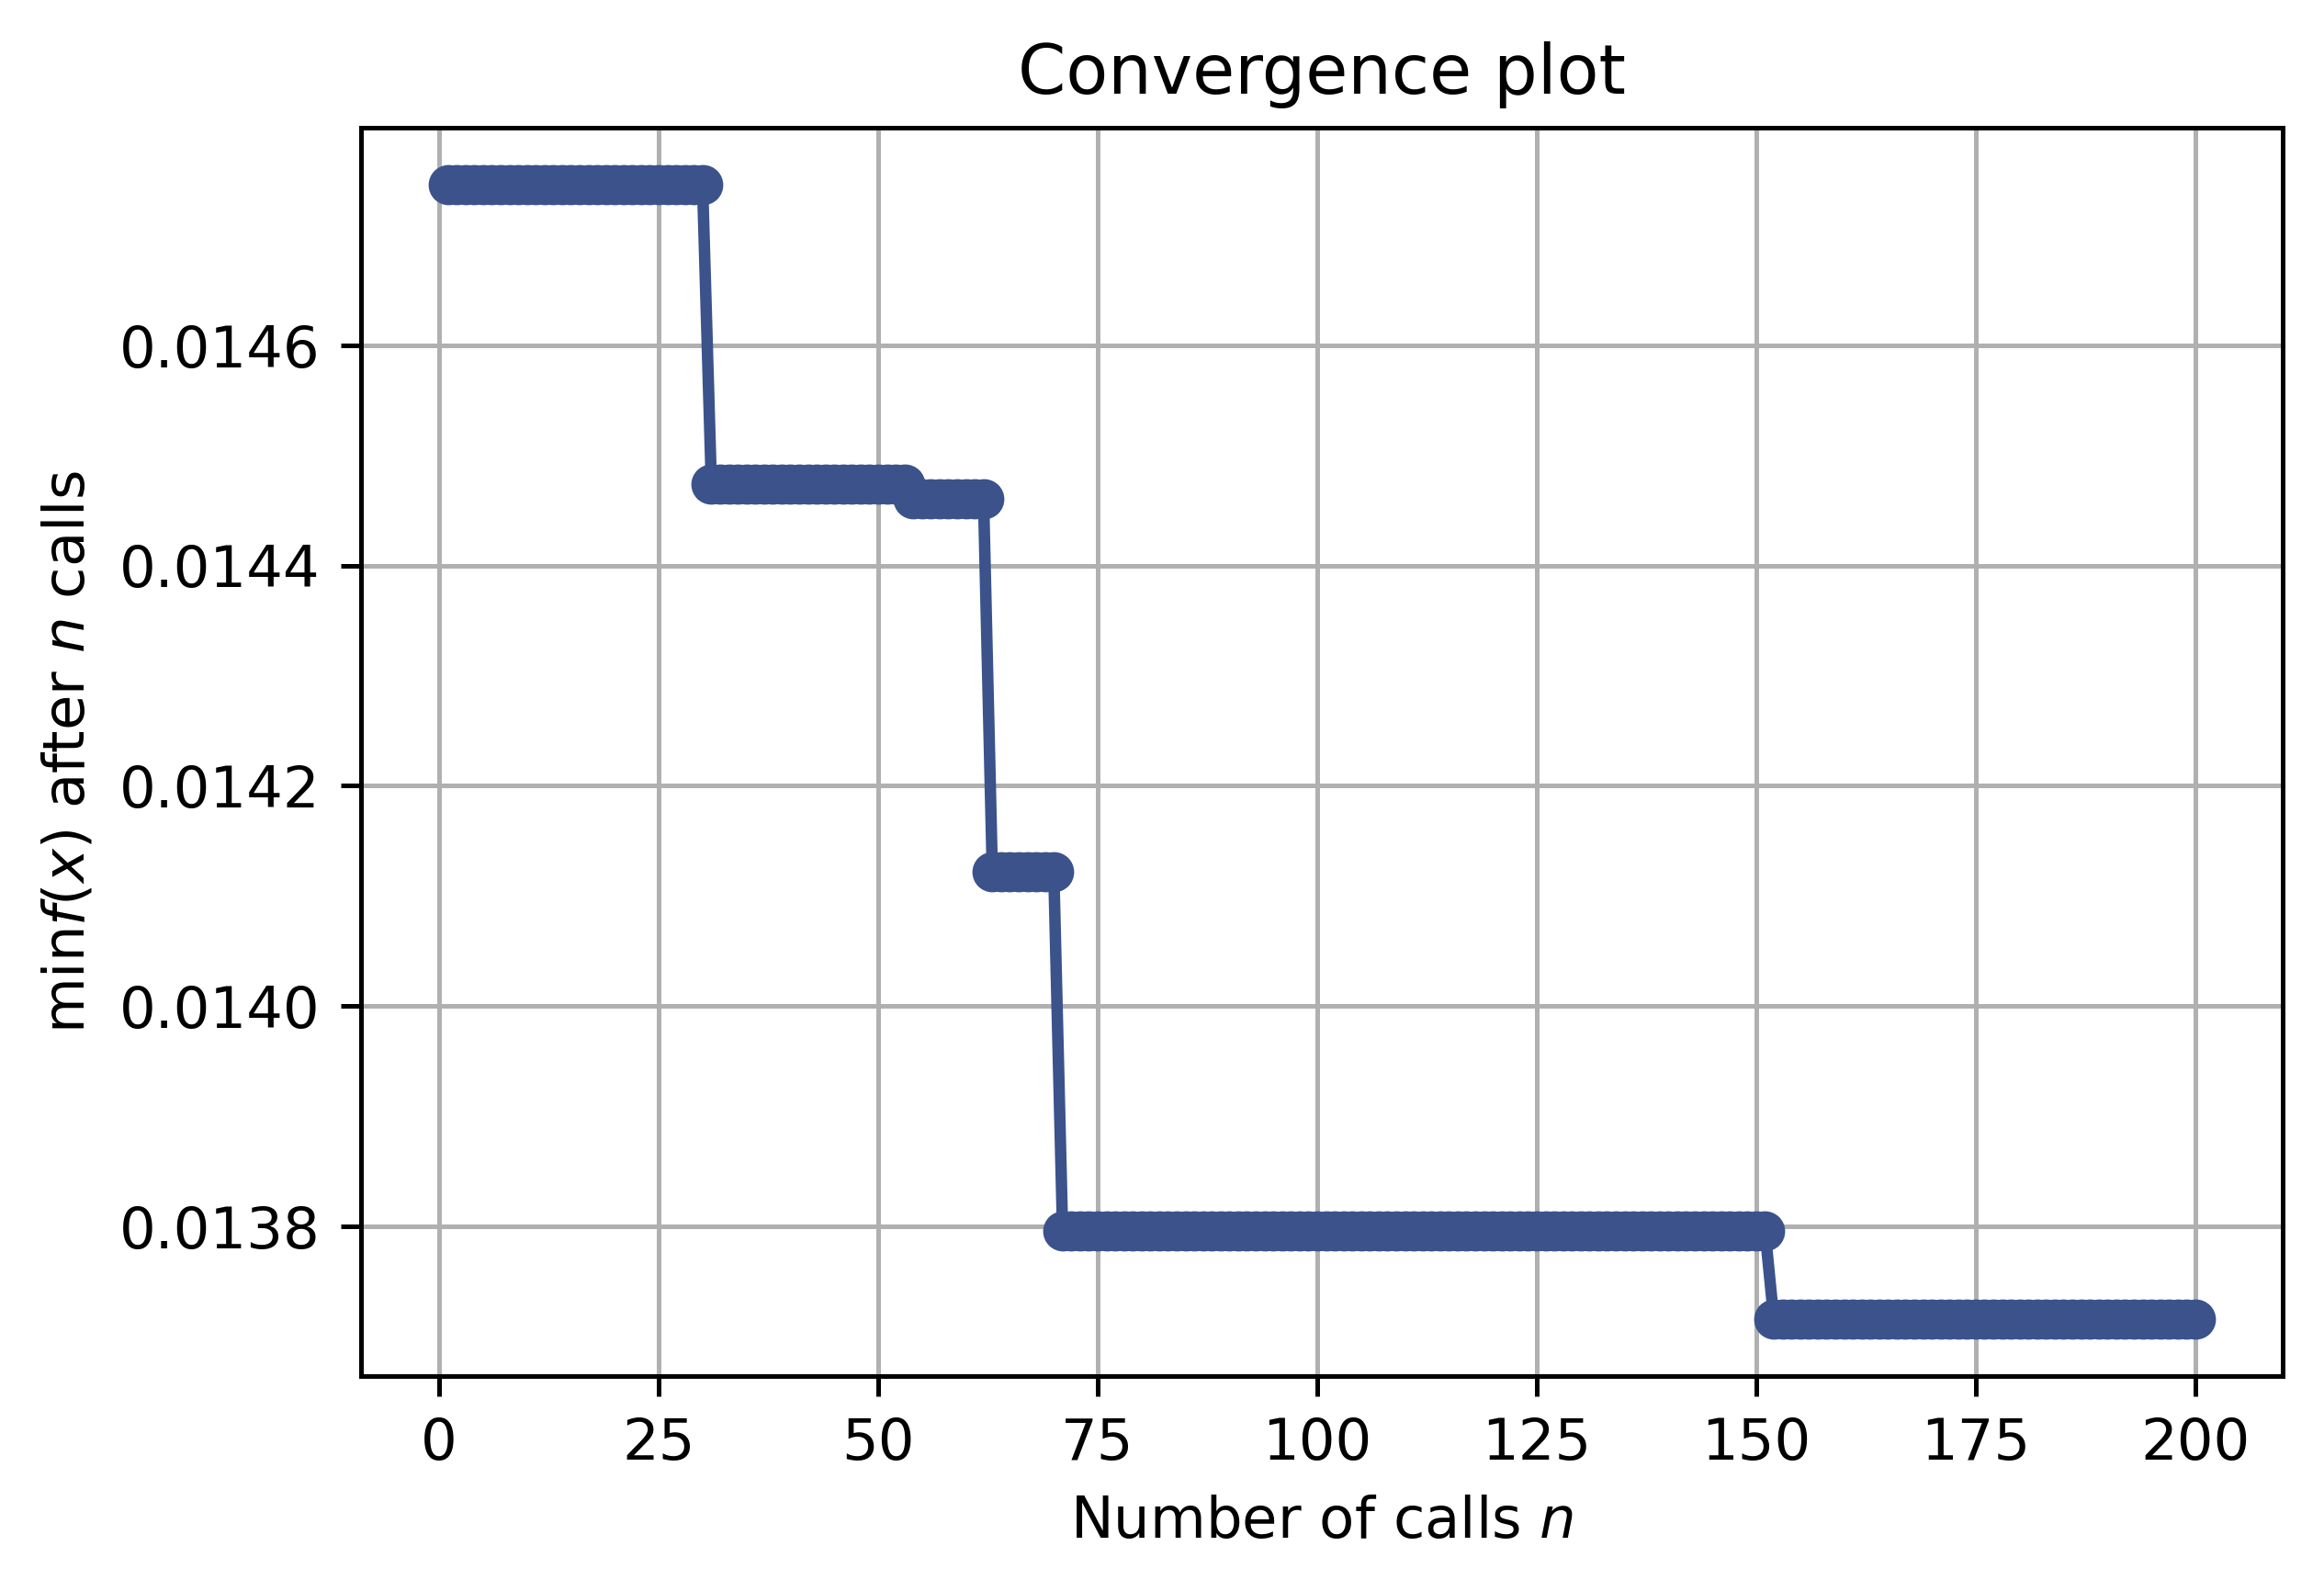

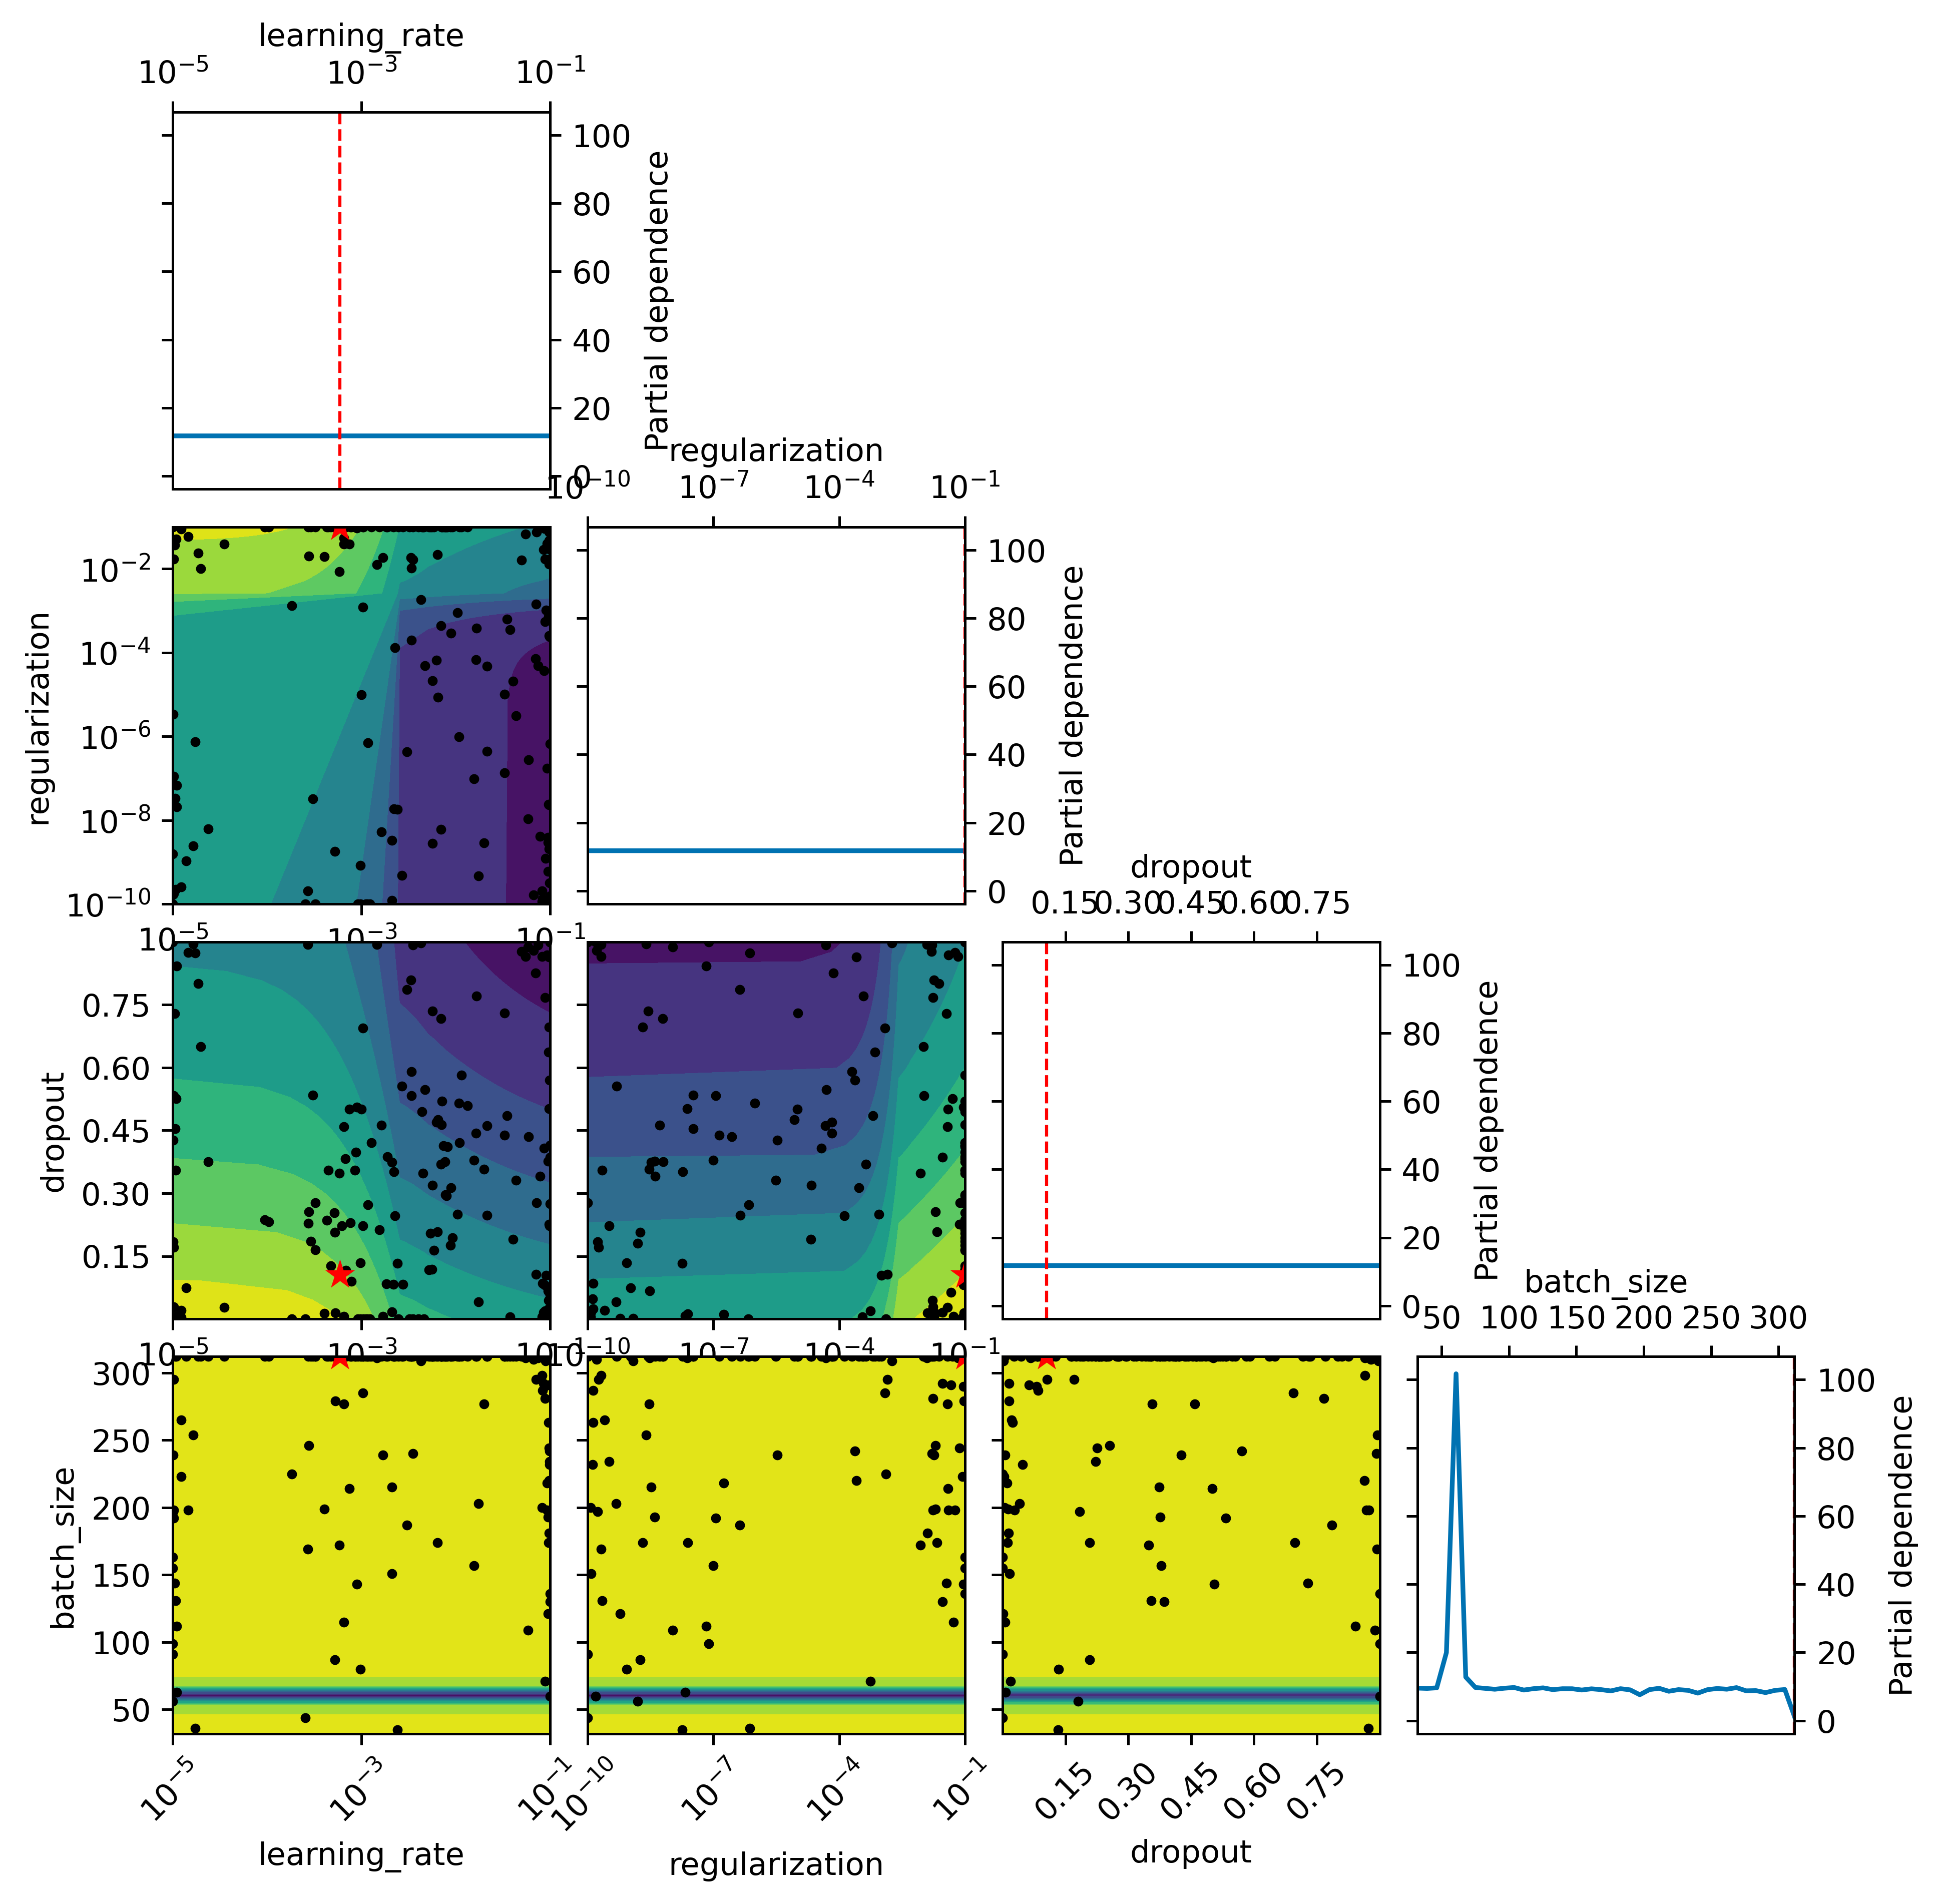

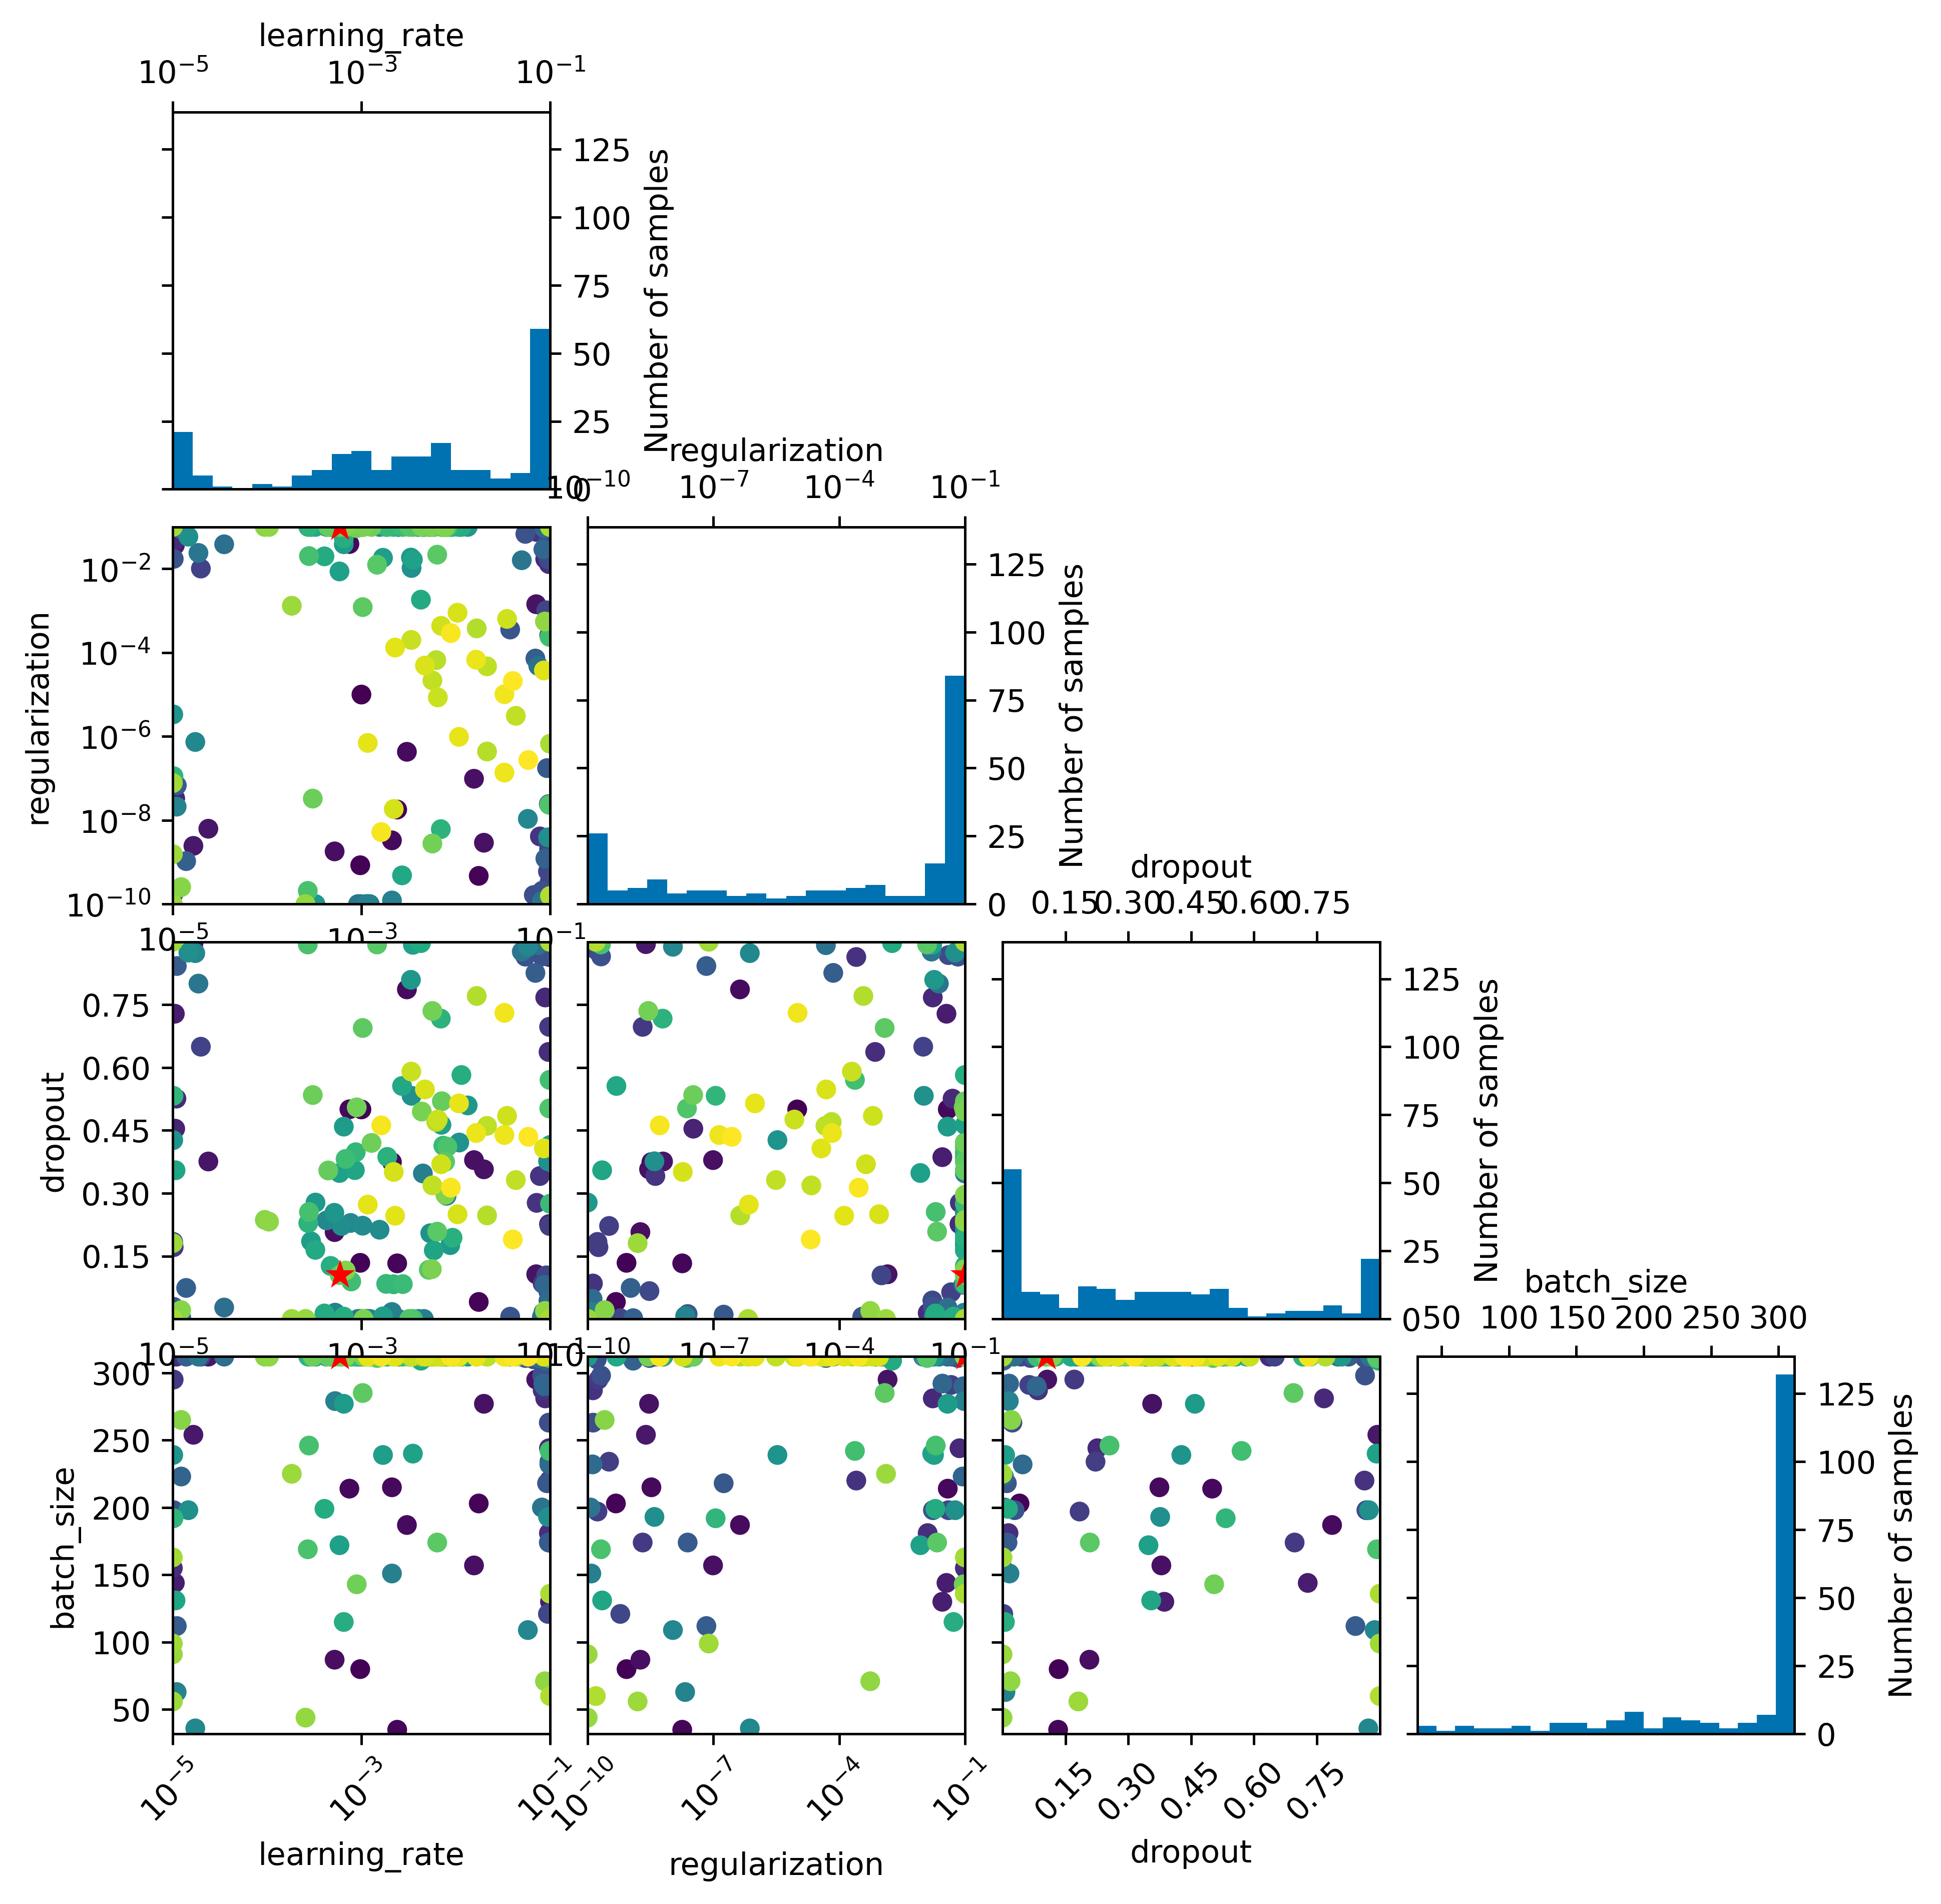

In [8]:
# ------------------- Bayesian optimization --------------------------------- #


class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()


# Set parameter search space
space = []
# space.append(Categorical(['relu', 'leakyrelu', 'elu'], name='activation'))
space.append(Real(1e-5, 1e-1, prior='log-uniform', name='learning_rate'))
space.append(Real(1e-10, 1e-1, prior='log-uniform', name='regularization'))
space.append(Real(0.0, 0.9, name='dropout'))
space.append(Integer(int(32), int(312), name='batch_size', dtype=int))

# Set default hyperparameters
default_params = [1e-3,
                  1e-5,
                  0.5,
                  312]

# Work in progress
@use_named_args(dimensions=space)
def fitness(learning_rate, regularization, dropout, batch_size):
    """Perform Bayesian Hyperparameter tuning."""

    # num_epochs = 2000
    # n_splits = 5
    # patience = 100
    # if activation == 'relu':
    #     activation = nn.ReLU()
    # elif activation == 'leakyrelu':
    #     activation = nn.LeakyReLU()
    # elif activation == 'elu':
    #     activation = nn.ELU()
    # print(f'Learning Rate: {learning_rate:.0e}, Regularization: {regularization:.0e}, ', end='')
    # print(f'Dropout: {dropout:.2f}')  #, Batch Size: {batch_size}')

    model = NeuralNet(activation=nn.ELU(), dropout=dropout)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=regularization)
    # Create k-fold cross validation
    best_losses, *_ = kfold_cv_train(n_epochs=2000, model=model,
                                     optimizer=optimizer, batch_size=batch_size)
    # print(f'Avg. best validation loss: {sum(best_losses)/n_splits}')

    return sum(best_losses)/n_splits

n_calls = 200
# Hyperparemeter search using Gaussian process minimization
gp_result = gp_minimize(func=fitness,
                        x0=default_params,
                        dimensions=space,
                        n_calls=n_calls,
                        verbose=True, callback=[tqdm_skopt(total=n_calls,
                                          desc='Gaussian Process')])

plot_convergence(gp_result)
plot_objective(gp_result)
plot_evaluations(gp_result)
gp_result.x